# [Wrap-up quiz 7](https://inria.github.io/scikit-learn-mooc/evaluation/evaluation_wrap_up_quiz.html)

In [1]:
import pandas as pd

cycling = pd.read_csv('./datasets/bike_rides.csv', index_col=0, parse_dates=True)
cycling.index.name = ''
target_name = 'power'
data, target = cycling.drop(columns=target_name), cycling[target_name]
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


## Data Handling

In [2]:
import numpy as np

In [3]:
new_data = {
    'speed^3': data['speed']**3,
    'speed': data['speed'],
    'sin(alpha)*speed' : np.sin(np.arctan(data['slope']))*data['speed'],
    'acc*speed': data['acceleration'].clip(lower=0)*data['speed']
}
new_data = pd.DataFrame(new_data)

In [4]:
new_data['sin(alpha)*speed'].mean()

-0.002709709612566326

## Linear predictive model

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=4) 
scaler = StandardScaler()
model = RidgeCV()

scaler.fit(new_data)
scaled_new_data = pd.DataFrame(scaler.transform(new_data),index=new_data.index, columns=new_data.columns)

### Cross validation

In [6]:
from sklearn.model_selection import ShuffleSplit, cross_validate

cv = ShuffleSplit(n_splits=4)
scores_linear = cross_validate(
    model, scaled_new_data, y=target,
    cv=cv, scoring='neg_mean_absolute_error',
    return_estimator=True,
    return_train_score=True,
)

In [7]:
print(
    f"Mean absolute error on the test sets: "
    f"{-scores_linear['test_score'].mean():.3f} ± "
    f"{scores_linear['test_score'].std():.3f}"
)

Mean absolute error on the test sets: 72.468 ± 1.238


In [8]:
scores_linear['estimator'][1].fit(new_data, target)

RidgeCV()

In [9]:
scores_linear['estimator'][1].coef_

array([8.95641209e-03, 1.26178534e+01, 3.23619060e+02, 1.03469648e+01])

## Predictive model with original data

In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True)

cv = ShuffleSplit(n_splits=4)
scores_hist = cross_validate(
    model, data, y=target,
    cv=cv, scoring='neg_mean_absolute_error',
    return_estimator=True,
    return_train_score=True,
)

In [11]:
print(
    f"Mean absolute error on the test sets: "
    f"{-scores_hist['test_score'].mean():.3f} ± "
    f"{scores_hist['test_score'].std():.3f}"
)

Mean absolute error on the test sets: 43.330 ± 1.217


## Comparing the two models

In [12]:
scores_linear

{'fit_time': array([0.04560637, 0.03683805, 0.04315448, 0.04491615]),
 'score_time': array([0.00822711, 0.00908256, 0.00548744, 0.01016688]),
 'estimator': [RidgeCV(), RidgeCV(), RidgeCV(), RidgeCV()],
 'test_score': array([-72.31667642, -71.00242473, -72.12395835, -74.42741317]),
 'train_score': array([-72.49167937, -72.60905925, -72.4931107 , -72.240853  ])}

In [13]:
scores_hist

{'fit_time': array([0.80083728, 0.9858439 , 0.40906978, 0.52624345]),
 'score_time': array([0.0218842 , 0.0245316 , 0.01199818, 0.01719117]),
 'estimator': [HistGradientBoostingRegressor(early_stopping=True, max_iter=1000),
  HistGradientBoostingRegressor(early_stopping=True, max_iter=1000),
  HistGradientBoostingRegressor(early_stopping=True, max_iter=1000),
  HistGradientBoostingRegressor(early_stopping=True, max_iter=1000)],
 'test_score': array([-43.31548689, -41.71571811, -45.14264181, -43.14449558]),
 'train_score': array([-39.7900123 , -37.59382439, -41.08843416, -39.80068862])}

## Group cross validation

In [14]:
rides = len(pd.Series(data.index.date).unique())
rides

4

In [15]:
groups = pd.factorize(data.index.date)[0]

In [16]:
len(groups) == len(data)

True

In [17]:
from sklearn.model_selection import LeaveOneGroupOut

cv = LeaveOneGroupOut()

In [18]:
model = HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True)

scores_hist = cross_validate(
    model, data, y=target,
    cv=cv, groups=groups, scoring='neg_mean_absolute_error',
    return_estimator=True,
    return_train_score=True,
)
scores_hist

{'fit_time': array([0.66814327, 0.85300159, 0.72272444, 0.41222143]),
 'score_time': array([0.04192042, 0.04707503, 0.04188299, 0.0230782 ]),
 'estimator': [HistGradientBoostingRegressor(early_stopping=True, max_iter=1000),
  HistGradientBoostingRegressor(early_stopping=True, max_iter=1000),
  HistGradientBoostingRegressor(early_stopping=True, max_iter=1000),
  HistGradientBoostingRegressor(early_stopping=True, max_iter=1000)],
 'test_score': array([-48.08993346, -48.65334791, -54.10710087, -48.65737105]),
 'train_score': array([-37.64198378, -36.90105101, -36.03893717, -41.11716458])}

In [19]:
print(
    f"Mean absolute error on the test sets: "
    f"{-scores_hist['test_score'].mean():.3f} ± "
    f"{scores_hist['test_score'].std():.3f}"
)
print(
    f"Mean absolute error on the train sets: "
    f"{-scores_hist['train_score'].mean():.3f} ± "
    f"{scores_hist['train_score'].std():.3f}"
)

Mean absolute error on the test sets: 49.877 ± 2.453
Mean absolute error on the train sets: 37.925 ± 1.928


In [20]:
model = RidgeCV()

scores_linear = cross_validate(
    model, scaled_new_data, y=target,
    cv=cv, groups=groups, scoring='neg_mean_absolute_error',
    return_estimator=True,
    return_train_score=True,
)
scores_linear

{'fit_time': array([0.01484704, 0.0199194 , 0.02133226, 0.02659369]),
 'score_time': array([0.00270271, 0.0048542 , 0.00483465, 0.00516677]),
 'estimator': [RidgeCV(), RidgeCV(), RidgeCV(), RidgeCV()],
 'test_score': array([-72.44060496, -73.32064411, -81.30751786, -64.99051728]),
 'train_score': array([-72.43175577, -72.28703286, -68.96504583, -75.31153691])}

In [21]:
print(
    f"Mean absolute error on the test sets: "
    f"{-scores_linear['test_score'].mean():.3f} ± "
    f"{scores_linear['test_score'].std():.3f}"
)
print(
    f"Mean absolute error on the train sets: "
    f"{-scores_linear['train_score'].mean():.3f} ± "
    f"{scores_linear['train_score'].std():.3f}"
)

Mean absolute error on the test sets: 73.015 ± 5.779
Mean absolute error on the train sets: 72.249 ± 2.247


# Prediction of a single ride

In [22]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = scaled_new_data.iloc[train_indices]
data_linear_model_test = scaled_new_data.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

In [23]:
model_hist = HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True)
model_hist.fit(data_train, target_train)
model_hist_predictions = model_hist.predict(data_test)

model_linear = RidgeCV()
model_linear.fit(data_linear_model_train, target_train)
model_linear_predictions = model_linear.predict(data_linear_model_test)

Text(0.5, 1.0, 'HGBR model')

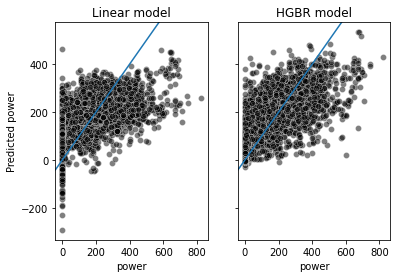

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2, sharey=True)

sns.scatterplot(
    x=target_test, y=model_linear_predictions, ax=ax[0], color='black', alpha=0.5,
)
ax[0].axline((0, 0), slope=1, label='Perfect fit')

sns.scatterplot(
    x=target_test, y=model_hist_predictions, ax=ax[1], color='black', alpha=0.5
)
ax[1].axline((0, 0), slope=1, label='Perfect fit')

ax[0].set_ylabel('Predicted power')
ax[0].set_title('Linear model')
ax[1].set_title('HGBR model')

In [30]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = scaled_new_data[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

model_hist_subset_predictions = model_hist.predict(data_test_subset)
model_linear_subset_predictions = model_linear.predict(data_test_linear_model_subset)

(-18.8, 446.65210259688706, -23.43020312012134, 442.0218994767657)

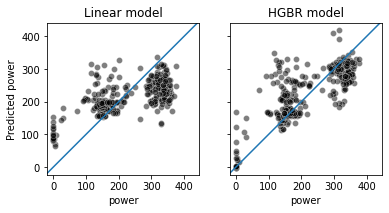

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2, sharey=True)

sns.scatterplot(
    x=target_test_subset, y=model_linear_subset_predictions, ax=ax[0], color='black', alpha=0.5,
)
ax[0].axline((0, 0), slope=1, label='Perfect fit')

sns.scatterplot(
    x=target_test_subset, y=model_hist_subset_predictions, ax=ax[1], color='black', alpha=0.5
)
ax[1].axline((0, 0), slope=1, label='Perfect fit')

ax[0].set_ylabel('Predicted power')
ax[0].set_title('Linear model')
ax[1].set_title('HGBR model')

ax[0].axis('square')
ax[1].axis('square')